# SNR verification

dataset: `32622_1_00002_00001.tif`

- per-zplane min subtraction

In [9]:
import numpy as np
import mbo_utilities as mbo
import matplotlib.pyplot as plt

In [10]:
# load exactly as the GUI does: phase correction off
arr = mbo.imread(r"E:\yao\stanford\32622_1_00002_00001\32622_1_00002_00001.tif")
arr.fix_phase = False
print(f"type: {type(arr).__name__}")
print(f"shape: {arr.shape}")
print(f"dims: {arr.dims}")
print(f"dtype: {arr.dtype}")
print(f"fix_phase: {arr.fix_phase}")

type: LBMArray
shape: (2000, 28, 440, 438)
dims: ('timepoints', 'z-planes', 'Y', 'X')
dtype: int16
fix_phase: False


In [11]:
# figure out slice iteration (same as GUI)
dims_lower = tuple(d.lower() for d in arr.dims)
has_c = any(d in dims_lower for d in ("channels", "channel", "c"))
n_slices = arr.shape[1]
label = "channel" if has_c else "z-plane"
print(f"iterating over {n_slices} {label}s")

iterating over 28 z-planes


In [12]:
# compare fix_phase off vs on — show stack.min() to understand the mean difference
path = r"E:\yao\stanford\32622_1_00002_00001\32622_1_00002_00001.tif"
arr_off = mbo.imread(path)
arr_off.fix_phase = False
arr_on = mbo.imread(path)
arr_on.fix_phase = True

n_z = arr_off.shape[1]

In [16]:

print(f"{'zplane':>6} | {'fix_phase=False':^36} | {'fix_phase=True':^36}")
print(f"{'':>6} | {'smin':>6} {'mean':>8} {'std':>8} {'snr':>8} | {'smin':>6} {'mean':>8} {'std':>8} {'snr':>8}")
print("-" * 84)

for s in range(n_z):
    stack_off = np.median(np.asarray(arr_off[::10, s]).astype(np.float32), axis=0)
    smin_off = float(stack_off.min())
    stack_off -= smin_off
    mean_off = np.mean(stack_off, axis=0)
    std_off = np.std(stack_off, axis=0)
    snr_off = np.zeros_like(mean_off)
    np.divide(mean_off, std_off + 1e-5, out=snr_off, where=(std_off > 1e-5))

    stack_on = np.median(np.asarray(arr_on[::10, s]).astype(np.float32), axis=0)
    smin_on = float(stack_on.min())
    stack_on -= smin_on
    mean_on = np.mean(stack_on, axis=0)
    std_on = np.std(stack_on, axis=0)
    snr_on = np.zeros_like(mean_on)
    np.divide(mean_on, std_on + 1e-5, out=snr_on, where=(std_on > 1e-5))

    print(f"{s+1:>6d} | {smin_off:>6.0f} {np.mean(mean_off):>8.2f} {np.mean(std_off):>8.2f} {np.mean(snr_off):>8.2f} | "
          f"{smin_on:>6.0f} {np.mean(mean_on):>8.2f} {np.mean(std_on):>8.2f} {np.mean(snr_on):>8.2f}")

zplane |           fix_phase=False            |            fix_phase=True           
       |   smin     mean      std      snr |   smin     mean      std      snr
------------------------------------------------------------------------------------
     1 |      0    21.96    29.76     7.00 |     -5    27.88    31.35     3.79
     2 |      0    25.90    44.53     8.28 |      0    25.65    44.55     7.79
     3 |      0    21.04    21.19     6.91 |      0    22.44    24.16     2.79
     4 |    -13    30.00     9.72    14.85 |    -14    31.27    11.58     6.20
     5 |      0    17.25    10.54     9.03 |     -1    19.22    13.20     3.49
     6 |      0    16.06    12.95     8.27 |      0    16.34    13.82     4.61
     7 |      0    23.03    33.34     8.75 |      0    22.78    33.37     8.30
     8 |      0    18.89    13.15     9.25 |      0    19.95    15.92     3.32
     9 |      0    18.91    17.95     7.52 |    -28    47.84    20.45     7.04
    10 |      0    18.94    19.06     8.

fix_phase=False: min=-59, max=5335, mean=68.9
fix_phase=True:  min=-361, max=5266, mean=68.8


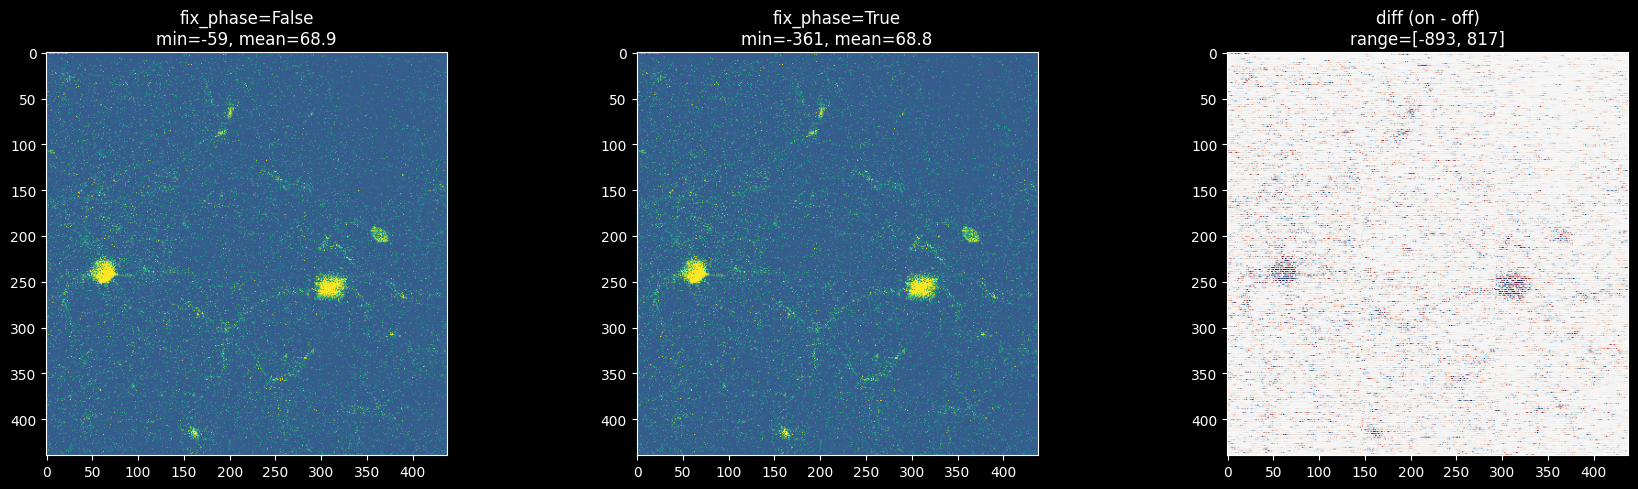

In [14]:
# single frame comparison: zplane 0, fix_phase off vs on
frame_off = np.asarray(arr_off[0, 0]).astype(np.float32)
frame_on = np.asarray(arr_on[0, 0]).astype(np.float32)

print(f"fix_phase=False: min={frame_off.min():.0f}, max={frame_off.max():.0f}, mean={frame_off.mean():.1f}")
print(f"fix_phase=True:  min={frame_on.min():.0f}, max={frame_on.max():.0f}, mean={frame_on.mean():.1f}")

vmin = min(frame_off.min(), frame_on.min())
vmax = max(np.percentile(frame_off, 99.5), np.percentile(frame_on, 99.5))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(frame_off, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title(f'fix_phase=False\nmin={frame_off.min():.0f}, mean={frame_off.mean():.1f}')

axes[1].imshow(frame_on, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title(f'fix_phase=True\nmin={frame_on.min():.0f}, mean={frame_on.mean():.1f}')

diff = frame_on - frame_off
axes[2].imshow(diff, cmap='RdBu_r', vmin=-200, vmax=200)
axes[2].set_title(f'diff (on - off)\nrange=[{diff.min():.0f}, {diff.max():.0f}]')

plt.tight_layout()
plt.show()

In [19]:
# AAPM standard: SNR = (mean_signal - mean_background) / std_background
# use fixed percentile on mean image to split foreground/background
# top 20% brightest pixels = signal region, bottom 50% = background region

n_z = arr_off.shape[1]
print(f"{'zplane':>6} | {'fix_phase=False':^36} | {'fix_phase=True':^36}")
print(f"{'':>6} | {'fg_mean':>8} {'bg_mean':>8} {'bg_std':>8} {'snr':>6} | {'fg_mean':>8} {'bg_mean':>8} {'bg_std':>8} {'snr':>6}")
print("-" * 88)

for s in range(n_z):
    # phase off
    stack_off = np.asarray(arr_off[::10, s]).astype(np.float32)
    mean_off = np.mean(stack_off, axis=0)
    p80_off = np.percentile(mean_off, 80)
    p50_off = np.percentile(mean_off, 50)
    fg_off = mean_off >= p80_off
    bg_off = mean_off <= p50_off
    fg_mean_off = mean_off[fg_off].mean()
    bg_mean_off = mean_off[bg_off].mean()
    bg_std_off = mean_off[bg_off].std()
    snr_off = (fg_mean_off - bg_mean_off) / bg_std_off if bg_std_off > 0 else 0

    # phase on
    stack_on = np.asarray(arr_on[::10, s]).astype(np.float32)
    mean_on = np.mean(stack_on, axis=0)
    p80_on = np.percentile(mean_on, 80)
    p50_on = np.percentile(mean_on, 50)
    fg_on = mean_on >= p80_on
    bg_on = mean_on <= p50_on
    fg_mean_on = mean_on[fg_on].mean()
    bg_mean_on = mean_on[bg_on].mean()
    bg_std_on = mean_on[bg_on].std()
    snr_on = (fg_mean_on - bg_mean_on) / bg_std_on if bg_std_on > 0 else 0

    print(f"{s+1:>6d} | {fg_mean_off:>8.2f} {bg_mean_off:>8.2f} {bg_std_off:>8.2f} {snr_off:>6.2f} | "
          f"{fg_mean_on:>8.2f} {bg_mean_on:>8.2f} {bg_std_on:>8.2f} {snr_on:>6.2f}")

zplane |           fix_phase=False            |            fix_phase=True           
       |  fg_mean  bg_mean   bg_std    snr |  fg_mean  bg_mean   bg_std    snr
----------------------------------------------------------------------------------------
     1 |    91.88    28.09     4.25  14.99 |    91.73    27.91     4.28  14.93
     2 |   106.51    26.82     3.76  21.21 |   106.26    26.58     3.76  21.22
     3 |    79.58    28.17     3.94  13.06 |    79.39    28.01     4.05  12.69
     4 |    56.18    24.23     3.41   9.37 |    55.98    24.05     3.53   9.04
     5 |    64.43    24.85     3.54  11.18 |    64.26    24.66     3.69  10.72
     6 |    59.25    20.74     2.94  13.11 |    59.07    20.54     3.02  12.76
     7 |    91.17    24.55     3.45  19.30 |    90.90    24.30     3.45  19.30
     8 |    74.10    24.89     3.57  13.79 |    74.06    24.58     4.00  12.37
     9 |    73.80    23.34     3.31  15.24 |    73.88    22.96     3.91  13.02
    10 |    72.82    23.05     3.17 